In [ ]:
# Segmentation Library
!pip install -U segmentation-models-pytorch

# Import
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import csv
from sklearn.model_selection import train_test_split

# Model
import segmentation_models_pytorch as smp

# Preprocessing
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, jaccard_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
# Dataset Download
!wget -nc --no-check-certificate \
    "https://mm.cs.uec.ac.jp/uecfoodpix/UECFOODPIXCOMPLETE.tar" \
    -O "/content/dataset.tar"


!tar -xvf /content/dataset.tar

Streaming output truncated to the last 5000 lines.
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/509.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/539.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/598.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/637.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/744.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/775.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/869.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/913.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/1001.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/1031.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/1061.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/11066.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/14421.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/10761.png
UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/1225.png
UECFOODPI

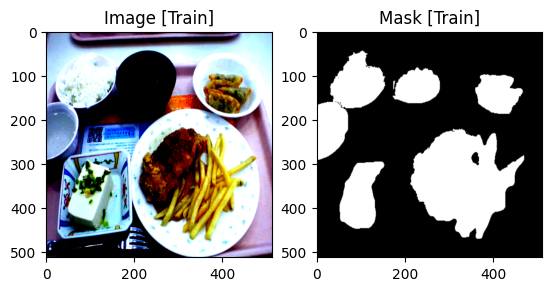

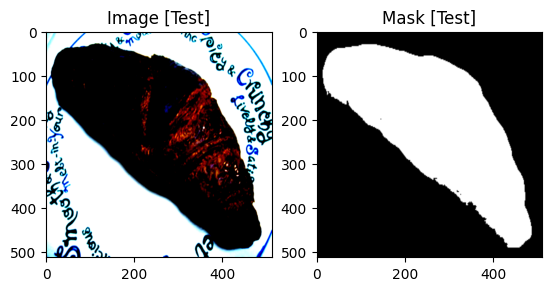

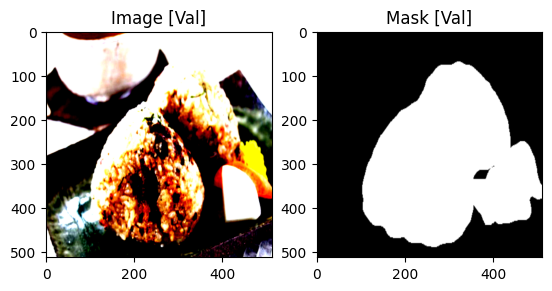

In [ ]:
# Dataset class
class CustomDatasetUEC(Dataset):
    def __init__(self, image_names_file, image_dir, mask_dir, transform=None):
        self.image_names_file = image_names_file
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = []
        self.image_paths = {}  # Dictionary that stores images path
        self.masks = []
        self.load_data()

        # Pre-processing
        self.preprocess_input = smp.encoders.get_preprocessing_fn('resnet34', pretrained='imagenet')

        # Define a transformation for the preprocessing function
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

    def load_data(self):
        with open(self.image_names_file) as f:
            for line in f:
                image_name = line.strip()
                self.image_names.append(image_name)

    def load_image(self, image_path):
        image = Image.open(image_path)
        return image

    def load_mask(self, mask_path):
        mask = Image.open(mask_path).convert("RGB")
        red_channel = mask.split()[0]  # Estract red channel
        binary_mask = np.where(np.array(red_channel) > 0, 1, 0)  # Convert to binary
        binary_mask_image = Image.fromarray((binary_mask * 255).astype(np.uint8), mode="L")  # Convert to binary
        return binary_mask_image

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.image_names[index]

        if image_name not in self.image_paths:
            image_path = os.path.join(self.image_dir, image_name + ".jpg")
            self.image_paths[image_name] = image_path

        image = self.load_image(self.image_paths[image_name])
        mask_path = os.path.join(self.mask_dir, image_name + ".png")
        mask = self.load_mask(mask_path)

        if self.transform:
            image = self.transform(image)
            image = image.numpy().transpose((1, 2, 0))  # Convert to numpy and transpose to HWC
            image = self.preprocess_input(image)  # Apply preprocessing function
            image = torch.tensor(image).permute(2, 0, 1).float()  # Convert back to tensor and transpose to CHW
            mask = self.transform(mask)

        return image, mask

# Set dir train set
image_names_file = "/content/UECFOODPIXCOMPLETE/data/train9000.txt"
image_dir = "/content/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/img"
mask_dir = "/content/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask"

# Set dir for test set
test_image_names_file = "/content/UECFOODPIXCOMPLETE/data/test1000.txt"
test_image_dir = "/content/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/img"
test_mask_dir = "/content/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/mask"

# Create val set from split test set
# Set dir for val set
val_image_dir = "/content/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/val/img"
val_mask_dir = "/content/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/val/mask"
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

# Read image names from file
with open(image_names_file) as f:
    image_names = [line.strip() for line in f]

# Perform split 80 - 20
image_names_file_s, val_image_names_file_s = train_test_split(image_names, test_size=0.2, shuffle=False)

# Move images and masks to val folder
for name in val_image_names_file_s:
    val_image_path = os.path.join(image_dir, name + '.jpg')
    val_mask_path = os.path.join(mask_dir, name + '.png')

    if not os.path.exists(os.path.join(val_image_dir, name + '.jpg')):
        shutil.move(val_image_path, val_image_dir)

    if not os.path.exists(os.path.join(val_mask_dir, name + '.png')):
        shutil.move(val_mask_path, val_mask_dir)

# Create new 800 images/masks train set
with open('/content/UECFOODPIXCOMPLETE/data/train7200.txt', 'w') as f:
    for line in image_names_file_s:
        f.write(line.strip() + '\n')
image_names_file_7200 = "/content/UECFOODPIXCOMPLETE/data/train7200.txt"

# Create new 200 images/masks val set
with open('/content/UECFOODPIXCOMPLETE/data/val1800.txt', 'w') as f:
    for line in val_image_names_file_s:
        f.write(line.strip() + '\n')
val_image_names_file_1800 = "/content/UECFOODPIXCOMPLETE/data/val1800.txt"

# Create train dataset/dataloader
dataset = CustomDatasetUEC(image_names_file_7200, image_dir, mask_dir)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

# Create test dataset/dataloader
test_dataset = CustomDatasetUEC(test_image_names_file, test_image_dir, test_mask_dir)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Create val dataset/dataloader
val_dataset = CustomDatasetUEC(val_image_names_file_1800, val_image_dir, val_mask_dir)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

# Access the data
image, mask = dataset[1]
test_image, test_mask = test_dataset[1]
val_image, val_mask = val_dataset[2]

# Visualize train image and mask
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.permute(1, 2, 0).numpy())
ax[0].set_title("Image [Train]")
ax[1].imshow(mask.squeeze(), cmap='gray')
ax[1].set_title("Mask [Train]")
plt.show()

# Visualize test image and mask
fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_image.permute(1, 2, 0).numpy())
ax[0].set_title("Image [Test]")
ax[1].imshow(test_mask.squeeze(), cmap='gray')
ax[1].set_title("Mask [Test]")
plt.show()

# Visualize val image and mask
fig, ax = plt.subplots(1, 2)
ax[0].imshow(val_image.permute(1, 2, 0).numpy())
ax[0].set_title("Image [Val]")
ax[1].imshow(val_mask.squeeze(), cmap='gray')
ax[1].set_title("Mask [Val]")
plt.show()

In [ ]:
# Model Definition
model = smp.Unet(
    encoder_name="resnet34",
    encoder_depth=5,
    encoder_weights='imagenet',
    decoder_use_batchnorm=True,
    decoder_channels=(256, 128, 64, 32, 16),
    decoder_attention_type=None,
    in_channels=3,
    classes=1,
    activation='sigmoid',
    aux_params=None
)

# Define loss function, and optimizer
loss = smp.losses.DiceLoss(mode="binary")

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 397MB/s]


Epoch 1/15
----------
Batch 0/900 - Loss: 0.5089205503463745
Batch 100/900 - Loss: 0.3931436538696289
Batch 200/900 - Loss: 0.3926818370819092
Batch 300/900 - Loss: 0.3869629502296448
Batch 400/900 - Loss: 0.37030452489852905
Batch 500/900 - Loss: 0.37606126070022583
Batch 600/900 - Loss: 0.40058374404907227
Batch 700/900 - Loss: 0.3784211277961731
Batch 800/900 - Loss: 0.4763323664665222
Accuracy: 0.912
Precision: 0.829
Recall: 0.965
F1 Score: 0.892
Jaccard Score: 0.805
 
Validation Set
----------
Batch 0/225 - Loss: 0.443703830242157
Batch 100/225 - Loss: 0.29880475997924805
Batch 200/225 - Loss: 0.43380749225616455
F1 Score: 0.8697178844353158
Jaccard Score: 0.769469738978227
 
Epoch 2/15
----------
Batch 0/900 - Loss: 0.40666627883911133
Batch 100/900 - Loss: 0.35021066665649414
Batch 200/900 - Loss: 0.3842581510543823
Batch 300/900 - Loss: 0.3241202235221863
Batch 400/900 - Loss: 0.4393773078918457
Batch 500/900 - Loss: 0.38963407278060913
Batch 600/900 - Loss: 0.41760021448135376

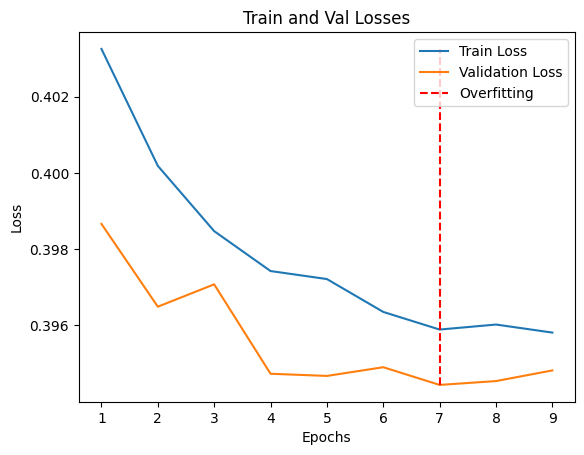

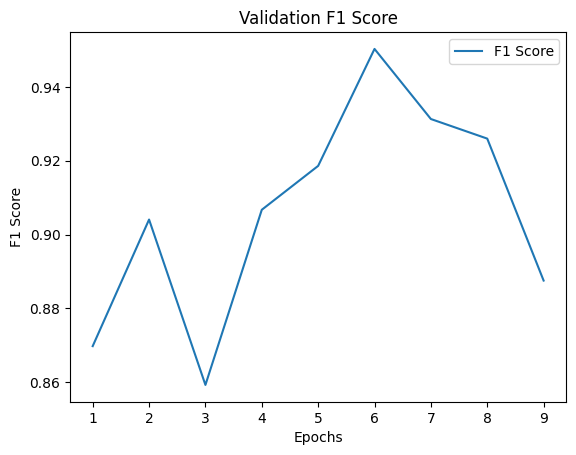

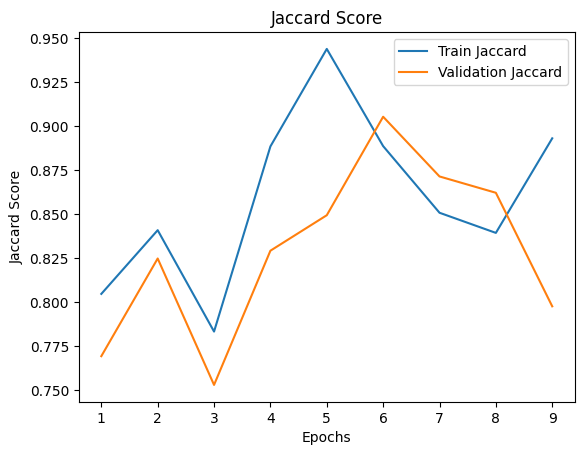

 
Best Train Epoch: 5
 
Validation Overfit in Epoch: 7 with value: 0.3945437346564399


In [ ]:
# TRAIN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss.to(device)

# Early Stopping
best_metric = 0.0
no_improvement_epochs = 0
patience = 3  # Maximum number of epochs without improvement to be tolerated
val_metrics = []

# Calculate Losses, Jaccard and F1
train_losses = []
val_losses = []
train_jaccard = []
val_jaccard = []
val_f1_scores = []

# Epochs
num_epochs = 15
epoch_loss = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    model.train()  # Set model to training mode

    for batch_idx, (images, masks) in enumerate(data_loader):

        # To GPU
        images = images.to(device)
        masks = masks.to(device)

        # Optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Convert masks to index tensor
        masks = masks.round().long()

        # Calculate loss
        loss_value = loss(outputs, masks)

        # Accumulate loss
        epoch_loss += loss_value.item()

        # Compute predicted labels
        predicted_labels = torch.argmax(outputs, dim=1)

        # Treshold predicted
        predicted_labels = torch.where(outputs > 0.5, torch.tensor(1), torch.tensor(0))

        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(data_loader)} - Loss: {loss_value.item()}")

    # Compute metrics after each epoch
    y_pred = predicted_labels.cpu().flatten()
    y_true = masks.cpu().flatten()

    accuracy = accuracy_score(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)
    train_jaccard.append(jaccard)

    accuracy = round(accuracy, 3)
    precision = round(precision, 3)
    recall = round(recall, 3)
    f1 = round(f1, 3)
    jaccard = round(jaccard, 3)

    # Print or store the metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Jaccard Score:", jaccard)
    print(" ")

    # Compute average loss
    epoch_loss /= len(data_loader)
    train_losses.append(epoch_loss)

    # Early stopping
    model.eval()

    with torch.no_grad():

        print(f"Validation Set")
        print("-" * 10)

        epoch_val_loss = 0

        for batch_idx, (val_image, val_mask) in enumerate(val_data_loader):

            # To GPU
            val_image = val_image.to(device)
            val_mask = val_mask.to(device)

            # Forward pass
            outputs = model(val_image)

            # Convert masks to index tensors
            val_mask = val_mask.round().long()

            # Calculate loss
            loss_value = loss(outputs, val_mask)

            # Save validation loss
            epoch_val_loss += loss_value.item()

            # Calculate the predicted labels
            predicted_labels = torch.argmax(outputs, dim=1)

            # Treshold predicted
            predicted_labels = torch.where(outputs > 0.5, torch.tensor(1), torch.tensor(0))

            if batch_idx % 100 == 0:
              print(f"Batch {batch_idx}/{len(val_data_loader)} - Loss: {loss_value.item()}")

        # Compute metrics after each epoch
        y_pred = predicted_labels.cpu().flatten()
        y_true = val_mask.cpu().flatten()

        # Compute average loss
        epoch_val_loss /= len(val_data_loader)
        val_losses.append(epoch_val_loss)

        # Compute Jaccard score
        val_jacc = jaccard_score(y_true, y_pred)
        val_jaccard.append(val_jacc)

        # Compute F1 score
        f1 = f1_score(y_true, y_pred)
        val_f1_scores.append(f1)

        # Set early stopping metric
        current_metric = val_f1_scores[-1]
        print("F1 Score:", current_metric)
        print("Jaccard Score:", val_jacc)
        print(" ")

        # Check for improvement
        if current_metric > best_metric:
            best_metric = current_metric
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        # Check if number of epochs without improvement reached the patience threshold
        if no_improvement_epochs >= patience:
            print(f"Early stopping: F1 score has not improved for {patience} epochs")
            print(f"Best F1 score: {best_metric}")
            print(f" ")
            break


# Plot Loss
train_epochs = [i+1 for i in range(len(train_losses))]
val_epochs = [i+1 for i in range(len(val_losses))]

plt.plot(train_epochs, train_losses, label='Train Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')

# Find min and max of losses and trace overfit line
min_epoch = val_epochs[val_losses.index(min(val_losses))]
min_loss = min(min(train_losses), min(val_losses))
max_loss = max(max(train_losses), max(val_losses))
plt.vlines(min_epoch, min_loss, max_loss, linestyles='--', colors='red', label='Overfitting')
plt.title('Train and Val Losses')
plt.xlabel('Epochs')
plt.xticks(val_epochs)
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation F1 score
plt.plot(val_epochs, val_f1_scores, label='F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.xticks(val_epochs)
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Plt Jaccard
train_epochs_jacc = [i+1 for i in range(len(train_jaccard))]
val_epochs_jacc = [i+1 for i in range(len(val_jaccard))]
plt.plot(train_epochs_jacc, train_jaccard, label='Train Jaccard')
plt.plot(val_epochs_jacc, val_jaccard, label='Validation Jaccard')
plt.title('Jaccard Score')
plt.xlabel('Epochs')
plt.xticks(val_epochs_jacc)
plt.ylabel('Jaccard Score')
plt.legend()
plt.show()

print(" ")
best_epoch = train_jaccard.index(max(train_jaccard))
print(f'Best Train Epoch: {best_epoch+1}')

print(" ")
if min_epoch == len(val_losses):
    print(f'')
else:
    print(f'Validation Overfit in Epoch: {min_epoch} with value: {val_losses[min_epoch]}')


In [ ]:
from google.colab import files

#Save checkpoint
torch.save(model.state_dict(), '/content/checkpointN_15_UNet_resnet34.pt')

files.download('/content/checkpointN_15_UNet_resnet34.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''
# Download ad Load Last Checkpoint
!wget --no-check-certificate \
    "https://www.dropbox.com/scl/fi/c8gb3v7cnc8xf2ec1pp73/checkpoint_15_UNet_resnet34.pt?rlkey=v19jv3dr442psas2sv7hg4z6m&st=fgpbb3bb&dl=1" \
    -O "/content/checkpoint_15_UNet_resnet34.pt"

model.load_state_dict(torch.load("/content/checkpoint_15_UNet_resnet34.pt"))

'''

'\n# Download ad Load Last Checkpoint\n!wget --no-check-certificate     "https://www.dropbox.com/scl/fi/c8gb3v7cnc8xf2ec1pp73/checkpoint_15_DeepLabV3_resnet34.pt?rlkey=v19jv3dr442psas2sv7hg4z6m&st=fgpbb3bb&dl=1"     -O "/content/checkpoint_15_DeepLabV3_resnet34.pt"\n\nmodel.load_state_dict(torch.load("/content/checkpoint_15_DeepLabV3_resnet34.pt"))\n\n'

In [ ]:
# TEST
import sklearn.metrics as metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss.to(device)

model.eval()

with torch.no_grad():
    for batch_idx, (test_image, test_mask) in enumerate(test_data_loader):

        # To GPU
        test_image = test_image.to(device)
        test_mask = test_mask.to(device)

        # Forward pass
        outputs = model(test_image)

        # Convert masks to index tensors
        test_mask = test_mask.round().long()

        loss_value = loss(outputs, test_mask)

        # Calculate the predicted labels
        predicted_labels = torch.argmax(outputs, dim=1)

        # Treshold predicted
        predicted_labels = torch.where(outputs > 0.5, torch.tensor(1), torch.tensor(0))

        # Some example images
        if batch_idx < 4:  # Only 2 batches
            for i in range(test_image.size(0)):
                image = test_image[i].cpu().numpy().transpose(1, 2, 0)  # Image to ndarray
                predicted_mask = predicted_labels[i].cpu().numpy()  # Predicted mask to ndarray
                original_mask = test_mask[i].cpu().numpy()  # Original mask to ndarray

                image = image / image.max()

                plt.figure()
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title("Image")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(predicted_mask.squeeze(), cmap='gray')
                plt.title("Predicted mask")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(np.squeeze(original_mask), cmap='gray')
                plt.title("Original mask")
                plt.axis('off')

                plt.show()

    # Compute metrics after each epoch
    y_pred = predicted_labels.cpu().flatten()
    y_true = test_mask.cpu().flatten()

    accuracy = accuracy_score(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)

    # Calculate the IoU for each class
    #iou_per_class = metrics.segmentation.mean_iou(y_true, y_pred, average='weighted')

    accuracy = round(accuracy, 3)
    precision = round(precision, 3)
    recall = round(recall, 3)
    f1 = round(f1, 3)
    jaccard = round(jaccard, 3)
    #miou = np.mean(iou_per_class)

    # Print the metrics
    print("")
    print("--- METRICS ---")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:")
    print(confusion)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Jaccard Score:", jaccard)
    #print("mIoU:", miou)

Output hidden; open in https://colab.research.google.com to view.